<h1 style="color:#98C1D9">Humans of Zeri Photo Archive</h1>
<h4>Abstract:</h4> 
<p>Our project focuses on the figure of the <b>photographer</b>, aiming at giving more information about an art which was long considered minor, or of support to major forms of Arts, such as painting and architecture etc.<br>
Through a series of investigation queries we tried to reveal all the essential data, thought to be useful to scholars of history of art specialized in photography.<br> The object of study in particular was <b><i>Zeri Photo Archive</i></b>, which was previously translated in LOD by the <i>Zeri & Lode</i> Project, and included in the <i>ARTchives</i> project. The desiderata of this project is for this model to be reused and applied to other similar resources in which it is necessary to <b>align data</b> to Wikidata or other RDF databases.</p>
<hr>
<p>This project was realized by Amanda Culoma, Giulia Morini and Andrea Schimmenti for the <b><i>Electronic Publishing and Digital Storytelling</i></b> (a.y. 2020-2021) final exam inside the <i>Digital Humanities and Digital Knowledge</i> Master's Degree at the University of Bologna.</p>

<h2 style="color:#98C1D9">Introduction: Exploring the <i>Zeri&Lode</i> RDF database </h2>

<p>The idea behind this project was to find more information about the <b>photographers</b> whose photos directly or undirectly became part of Federico Zeri's photo archive. As soon as we started our queries inside the <i>Zeri & Lode</i> database, we found little to no information regarding the photographers, apart from the labels of their names.</p> 
<p>This scenario was the first challenge of our research, since we had to find more information about those photographers without having a one to one link to the Wikidata IDs counterparts (or any other RDF database). Our reasoning was to find a possible match for every string that we found, then filtering the output of our <b>API request</b> via the RDF description of each of those matches.</p> 
    


<h5>Disclaimer:</h5>
<p>In order to create a research that is not only reproducible but also quickly viewable at any of its points, we decided to create <b>"intermediate" files</b>, apart from the file with the final results (data.json). The ability to do queries with a large amount of URIs is limited, requests to APIs and SPARQL endpoints not guaranteed at all times. However, this does not compromise the usability of these functions without them. Also, in case the databases get updated with new information,  restarting the functions will update the files too. At the moment the data has been updated on 02/07/2021 apart from the query from the Zeri&Lode database, which was last made in 25/06/2021.</p>

The following is a series of functions aided our research. 
Each of them is simple and serves a specific purpose (most functions are named after moments of an elegant dinner for wikidata entities. Don't ask why) 
* Initially a set of library imports for using the Python (3.10) code below.
* reverse_name(string): given a string with a comma + space (e.g. "Alinari, Fratelli"), it reverses its order (e.g. "Fratelli Alinari"). 
* invitation_list(data, string_to_match): given some strings (wikidata IDs) it adds them to a list 
* suit_for_SPARQL_dinner(list_of_uris): given a list of wikidata IDs, returns a list of "bracketed" uris for a SPARQLWrapper query 
* remove_uninvited_guests_from_list(uninvited_guests, invitation_list): given a list of people to remove, returns a list without the IDs you want to delete 
* afterparty_trash(filename, data_to_write): dumps a json object.

In [12]:
#libraries 
from SPARQLWrapper import SPARQLWrapper, JSON, GET, POST, CSV
import csv 
import pandas as pd
import requests
import json
import ssl
import numpy as np
import pandas as pd
import string
import networkx as nx
import matplotlib.pyplot as plt

#functions
def reverse_name(string): 
    comma = ', '
    string_to_join = ''
    if comma in string: 
        x = string.split(", ")
        string_to_join = str(x[1]) + ' '+ str(x[0])
        return string_to_join
    else: 
        return string
    
def invitation_list(data, string_to_match):
    invitated_uris = set()
    for result in data["results"]["bindings"]:
        invitated_uris.add(result[string_to_match]["value"]) 
        uris = list(invitated_uris)
    return uris
        
def suit_for_SPARQL_dinner(list_of_uris): 
    bracketed_uris = []
    for uri in list_of_uris:
        suited_uri = '<' + uri + '>'
        bracketed_uris.append(suited_uri)
    return bracketed_uris

#if you need to remove uris from a list, it's a basic linear search 
def remove_uninvited_guests_from_list(uninvited_guests, invitation_list):
    final_set = set()
    if len(invitation_list) < 2: 
        return None
    for person in uninvited_guests: 
        for i in range(len(invitation_list)):
            if (person == invitation_list[i]): 
                print('got out')
                print(person)
            else: 
                final_set.add(invitation_list[i])
    exclusive_list = list(final_set) 
    return exclusive_list

def afterparty_trash(filename, data_to_write):
    with open(filename, 'w') as outfile:
        json.dump(data_to_write, outfile)

<p>The following query via SPARQL finds all the photographers. The query path we chose first matches all the photos, then who managed the creation process (crm:P94i_was_created_by, crm:P14_carried_out_by). 
We also proceded to count all the occurrences of the holdsRoleInTime property, which shows how many contributions each photographer has inside <i>Zeri&Lode</i>.</p>   
<p>The output creates both a .csv file and a .json file.</p>

In [4]:
ssl._create_default_https_context = ssl._create_unverified_context

# get the endpoint API
fototeca_endpoint = "http://data.fondazionezeri.unibo.it/sparql"

my_SPARQL_query = """
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?photographer_label (COUNT(<http://purl.org/spar/pro/holdsRoleInTime>) as ?cnt)
WHERE { 
  	?x rdf:type <http://www.essepuntato.it/2014/03/fentry/Photograph> ; 
    crm:P94i_was_created_by ?creation .
    ?creation crm:P14_carried_out_by ?photographer .
    ?photographer rdfs:label ?photographer_label
 }
GROUP BY ?photographer_label 
ORDER BY DESC(?cnt) ?photographer_label
"""

# set the endpoint 
sparql_ft = SPARQLWrapper(fototeca_endpoint)
# set the query
sparql_ft.setQuery(my_SPARQL_query)
# set the returned format
sparql_ft.setReturnFormat(JSON)
# get the results
results = sparql_ft.query().convert()

with open('photographers.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['photographer', 'contribution_count'])
    for result in results["results"]["bindings"]:
        my_writer.writerow([result['photographer_label']['value'], result['cnt']['value'].strip()])
        
afterparty_trash("fototeca_photographers", results)

HTTPError: HTTP Error 503: Service Unavailable

<p>From the previous .csv file we extracted a sample of the first contributing entities. We can already notice the sheer amount of unrecognized authorships and the presence of both individuals, studios and institutions alike.</p>

In [13]:
data = pd.read_csv("photographers.csv")
data.head()

,"photographer,""contribution_count"""
0,"Anonimo,""13355"""
1,"Brogi, Giacomo,""2213"""
2,"ICCD: Fototeca Nazionale,""1539"""
3,"Fratelli Alinari,""1532"""
4,"Anderson, James,""1192"""


<p><b>Disclaimer:</b></p>
<p>The following phStringLimited.csv has been modified and accomodated to suit the string limit of the bokeh barchart. It has no other use. Here's a legend to recognise the used abbreviations.<p> 
<ul>
    <li>ICCD: Istituto Centrale per il Catalogo e la Documentazione: Fototeca Nazionale </li>
    <li>SSPSAE: Gabinetto Fotografico della Soprintendenza Speciale per il Patrimonio Storico, Artistico ed Etnoantropologico e per il Polo Museale della città di Firenze</li>

    

In [9]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.plotting import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import viridis
import pandas as pd
# read in csv

df = pd.read_csv("photographers2.csv")

source = ColumnDataSource(df)

photographer_list= source.data["photographer"].tolist()
contributions_list= source.data["contribution count"].tolist()

#Add plot
p = figure(
y_range= photographer_list,
plot_width= 800,
plot_height= 600,
title="Photographers contribution",
x_axis_label="Contributions",
tools="pan, box_select, zoom_in, zoom_out, save, reset"
)

#render glyph
p.hbar(
y="photographer",
right="contribution count",
left=0,
height=0.4,
fill_color=factor_cmap(
"photographer",
palette=viridis(len(photographer_list)),
factors=photographer_list
),
fill_alpha=0.9,
source=source,
legend_field="photographer"
)

#Show results
output_notebook()
show(p)

Loading BokehJS ...

In [15]:
import re 
import csv
institutions = {}

pattern = '([\w]+,)'

with open('photographers.csv') as csv_file:
    data = csv.DictReader(csv_file, delimiter=',')
    for row in data: 
        result = re.match(pattern, row['photographer'])
        if result:
            continue
        else: 
            if row['photographer'] != 'Anonimo':
                x = row['photographer'] 
                y = row['contribution count']
                institutions[x] = y

afterparty_trash('inst_contributions.json', institutions)

photographers = {}
with open('photographers.csv') as csv_file:
    data = csv.DictReader(csv_file, delimiter=',')
    for row in data: 
        result = re.match(pattern, row['photographer'])
        if result:
            x = row['photographer'] 
            y = row['contribution count']
            photographers[x] = y
        else: 
           continue

afterparty_trash('q5_contributions.json', photographers)

def total_contributions(dict):
    total = 0
    for key, value in dict.items(): 
        total = total + int(value) 
    return total 

print("The total contribution of the photographers is " + str(total_contributions(photographers)))
print("The total contribution of the institutions is " + str(total_contributions(institutions)))

The total contribution of the photographers is 7018
The total contribution of the institutions is 10786


<h3 style="color:#98C1D9">Wikidata API request from string data</h3>
<p>The following code is a string query to match the photographers from the Zeri Photo Archive with Wikidata entities. (The request may take some time so we added the results below). In case of multiple matches, wikidata provides a key called "search-continue" in the keys provided as output, so we can keep adding results. A few strings matched hundreds of entities, so the following Wikidata queries will try to clean and pick the correct ones. 
Some considerations about the code:</p>
<ol>
<li>The below code can be easily modified and turned into a function, with parameters (name_file, base_url and ['row_to_find'] instead of ['photographers'] in line 11. The reason why we didn't it's because it will be used only once in this project.</li>
<li>The code uses two of the functions above, reverse_name() and suit_for_SPARQL_dinner(); the reason we had to change the order "surname, name" into "name surname" is because the wikidata API often overlooked entities with the first format, while worked better with the second.</li>  
</ol>

In [38]:
ssl._create_default_https_context = ssl._create_unverified_context

name_file = open('fototeca_photographers.json') 
base_url = "https://www.wikidata.org/w/api.php?action=wbsearchentities&search=%s&language=en&format=json&limit=50"

data = json.load(name_file)
dict_of_results = {}
list_of_conceptualuris = []

for idx, row in enumerate(data["results"]["bindings"]):
    search_string = row["photographer_label"]["value"]
    search_string = reverse_name(search_string)
    final_str =  ('+'.join(search_string.split(' '))).strip()
    search_res = requests.get( base_url % final_str).json()
    n_results = len(search_res['search'])
    if(n_results == 0):
        continue

    search_results = []
    search_results.extend(search_res['search'])
    
    if('search-continue' in search_res.keys()):
        any_remaining_data = True
        continue_val = 1
        while(any_remaining_data):
            new_results = requests.get((base_url + ('&continue=%i'%continue_val)) % final_str).json()
            search_results.extend(new_results['search'])
            any_remaining_data ='search-continue' in  new_results.keys()
            continue_val += 1
    for s in search_results:
            list_of_conceptualuris.append(s['concepturi'])

uris = ' '.join(suit_for_SPARQL_dinner(list_of_conceptualuris))
print(uris)

<http://www.wikidata.org/entity/Q15140103> <http://www.wikidata.org/entity/Q4770013> <http://www.wikidata.org/entity/Q1324702> <http://www.wikidata.org/entity/Q12253600> <http://www.wikidata.org/entity/Q3354174> <http://www.wikidata.org/entity/Q2409629> <http://www.wikidata.org/entity/Q179174> <http://www.wikidata.org/entity/Q3618226> <http://www.wikidata.org/entity/Q3618225> <http://www.wikidata.org/entity/Q60185968> <http://www.wikidata.org/entity/Q100228480> <http://www.wikidata.org/entity/Q102358465> <http://www.wikidata.org/entity/Q102358464> <http://www.wikidata.org/entity/Q102358462> <http://www.wikidata.org/entity/Q102358466> <http://www.wikidata.org/entity/Q95842771> <http://www.wikidata.org/entity/Q102358459> <http://www.wikidata.org/entity/Q22264387> <http://www.wikidata.org/entity/Q21088952> <http://www.wikidata.org/entity/Q20007448> <http://www.wikidata.org/entity/Q4778526> <http://www.wikidata.org/entity/Q32827685> <http://www.wikidata.org/entity/Q4770016> <http://www.wik

<h2 style="color:#98C1D9">Alignment: extracting the photographers from the API request list of IDs</h2>

<p>At this point another disclaimer is due. A lot of the IDs we found from the request are, as expected, superfluous, so we needed to find a way to filter them. Fortunately enough, via a series of manual checks we made sure everyone was really listed in the Zeri&Lode database. We are conscious that this kind of approach is not perfect and needs refinement.</p>. 
<p>The list below describes the best strategy we found for our goal:</p>
<ol>
    <li>Filter the IDs via any property with the photographer or photographic studio as an object</li>
    <li>Filter the IDs again by searching any entity who was not an instance of human.</li>
    <li>From these photographic studios, extract the individuals who owned or worked inside of it.</li>
    <li>Remove from the list of IDs every studio from which individuals were extracted, via the two functions listed above <span style="color:#1fc600">invitation_list()</span> and <span style="color:#1fc600">remove_uninvited_guests_from_list()</span>.</li> 

Let's remove any entity who are not photographers (wd:Q33231) via the occupation property (wdt:P108) 

In [43]:
ssl._create_default_https_context = ssl._create_unverified_context

sparql = SPARQLWrapper("https://query.wikidata.org/bigdata/namespace/wdq/sparql")
sparql.setMethod(POST)

my_SPARQL_query= """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?photographer ?label 
WHERE {
    VALUES ?photographer {""" + uris + """} .
    ?photographer ?p ?o .
    FILTER (?o = wd:Q672070 || ?o = wd:Q33231)
    ?photographer rdfs:label ?label .
    FILTER(LANG(?label) = "en").
    }
GROUP BY ?photographer ?label 
"""
        
# set the endpoint 
# set the query
sparql.setQuery(my_SPARQL_query)
sparql.setMethod(POST)
# set the returned format
sparql.setReturnFormat(JSON)
# get the results
results = sparql.query().convert()
afterparty_trash("photographer_ids.json", results)
print(results)

{'head': {'vars': ['photographer', 'label']}, 'results': {'bindings': [{'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q64212'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Giorgio Sommer'}}, {'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q110373'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Wilhelm Castelli'}}, {'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q155158'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Kurt Schwitters'}}, {'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q215618'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Grete Stern'}}, {'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q346323'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Emery Walker'}}, {'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q378129'}, 'label': {'xml:lang': 'en', 'type': 'liter

Since some of the entities we found were actually studios of groups of people (such as Fratelli Alinari) we decided to find the actual people who were part of these groups, then put them all together as a new list of IDs, which will be the final version of the list we will use to retrieve more data. 

In [69]:
name_file = open('photographer_ids.json')
data = json.load(name_file)
uris = suit_for_SPARQL_dinner(invitation_list(data, "photographer"))
string_uris = ' '.join(uris)

print(string_uris)
#first query: find out if there's some group of people that isn't a Q5 themselves
#if there's someone, check if there's some people related to them and update the list of uris

if_entity = """select ?otherpeople ?photographer
where {VALUES  ?photographer  {"""+string_uris+"""}
    ?photographer wdt:P31 ?o .
    FILTER(?o != wd:Q5) . 
    ?photographer rdfs:label ?label .
    FILTER(LANG(?label) = "en").  
    ?photographer ?property ?otherpeople .
    ?otherpeople wdt:P31 wd:Q5 .
}

GROUP BY ?otherpeople ?photographer"""

sparql.setQuery(if_entity)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

print(results)

<http://www.wikidata.org/entity/Q106650408> <http://www.wikidata.org/entity/Q18169099> <http://www.wikidata.org/entity/Q43128341> <http://www.wikidata.org/entity/Q378129> <http://www.wikidata.org/entity/Q97940625> <http://www.wikidata.org/entity/Q102281190> <http://www.wikidata.org/entity/Q16632909> <http://www.wikidata.org/entity/Q346323> <http://www.wikidata.org/entity/Q55679892> <http://www.wikidata.org/entity/Q18509122> <http://www.wikidata.org/entity/Q106936993> <http://www.wikidata.org/entity/Q102280710> <http://www.wikidata.org/entity/Q21542680> <http://www.wikidata.org/entity/Q3157912> <http://www.wikidata.org/entity/Q75379946> <http://www.wikidata.org/entity/Q58242413> <http://www.wikidata.org/entity/Q110373> <http://www.wikidata.org/entity/Q106652385> <http://www.wikidata.org/entity/Q103135077> <http://www.wikidata.org/entity/Q107100391> <http://www.wikidata.org/entity/Q3831697> <http://www.wikidata.org/entity/Q102075978> <http://www.wikidata.org/entity/Q102282921> <http://ww

Now, let's extend our IDs list with all the individual photographers, then let's extract their labels first, then other data. 

In [70]:
uris.extend(suit_for_SPARQL_dinner(invitation_list(results, "otherpeople")))
#create a second list out of the other output, and have a list of the people to remove from the now unpacked list
people_out = suit_for_SPARQL_dinner(invitation_list(results, 'photographer'))
#use the two previous lists 
new_uris = remove_uninvited_guests_from_list(people_out, uris)
new_string_uris = ' '.join(new_uris)
print(new_string_uris)


got out
<http://www.wikidata.org/entity/Q2045337>
got out
<http://www.wikidata.org/entity/Q107097623>
got out
<http://www.wikidata.org/entity/Q85859399>
got out
<http://www.wikidata.org/entity/Q644689>
<http://www.wikidata.org/entity/Q18934975> <http://www.wikidata.org/entity/Q5660348> <http://www.wikidata.org/entity/Q62572993> <http://www.wikidata.org/entity/Q6187840> <http://www.wikidata.org/entity/Q946185> <http://www.wikidata.org/entity/Q61992274> <http://www.wikidata.org/entity/Q107097659> <http://www.wikidata.org/entity/Q16164590> <http://www.wikidata.org/entity/Q59575316> <http://www.wikidata.org/entity/Q107100391> <http://www.wikidata.org/entity/Q61482172> <http://www.wikidata.org/entity/Q61476278> <http://www.wikidata.org/entity/Q16622457> <http://www.wikidata.org/entity/Q107097566> <http://www.wikidata.org/entity/Q23560875> <http://www.wikidata.org/entity/Q85724045> <http://www.wikidata.org/entity/Q107030756> <http://www.wikidata.org/entity/Q86137496> <http://www.wikidata.org

In [74]:
new_string_uris = '''<http://www.wikidata.org/entity/Q18934975> <http://www.wikidata.org/entity/Q5660348> <http://www.wikidata.org/entity/Q62572993> <http://www.wikidata.org/entity/Q6187840> <http://www.wikidata.org/entity/Q946185> <http://www.wikidata.org/entity/Q61992274> <http://www.wikidata.org/entity/Q107097659> <http://www.wikidata.org/entity/Q16164590> <http://www.wikidata.org/entity/Q59575316> <http://www.wikidata.org/entity/Q107100391> <http://www.wikidata.org/entity/Q61482172> <http://www.wikidata.org/entity/Q61476278> <http://www.wikidata.org/entity/Q16622457> <http://www.wikidata.org/entity/Q107097566> <http://www.wikidata.org/entity/Q23560875> <http://www.wikidata.org/entity/Q85724045> <http://www.wikidata.org/entity/Q107030756> <http://www.wikidata.org/entity/Q86137496> <http://www.wikidata.org/entity/Q86736457> <http://www.wikidata.org/entity/Q106650408> <http://www.wikidata.org/entity/Q3723011> <http://www.wikidata.org/entity/Q346323> <http://www.wikidata.org/entity/Q17350272> <http://www.wikidata.org/entity/Q2045337> <http://www.wikidata.org/entity/Q2412846> <http://www.wikidata.org/entity/Q3157912> <http://www.wikidata.org/entity/Q99623889> <http://www.wikidata.org/entity/Q21543783> <http://www.wikidata.org/entity/Q55861391> <http://www.wikidata.org/entity/Q100138863> <http://www.wikidata.org/entity/Q18224771> <http://www.wikidata.org/entity/Q102281528> <http://www.wikidata.org/entity/Q86818261> <http://www.wikidata.org/entity/Q26242203> <http://www.wikidata.org/entity/Q18508704> <http://www.wikidata.org/entity/Q30127547> <http://www.wikidata.org/entity/Q60241073> <http://www.wikidata.org/entity/Q43128341> <http://www.wikidata.org/entity/Q17426655> <http://www.wikidata.org/entity/Q106936993> <http://www.wikidata.org/entity/Q17132342> <http://www.wikidata.org/entity/Q215618> <http://www.wikidata.org/entity/Q789672> <http://www.wikidata.org/entity/Q3750053> <http://www.wikidata.org/entity/Q12025975> <http://www.wikidata.org/entity/Q64212> <http://www.wikidata.org/entity/Q21176613> <http://www.wikidata.org/entity/Q102075978> <http://www.wikidata.org/entity/Q3081037> <http://www.wikidata.org/entity/Q30308759> <http://www.wikidata.org/entity/Q1349404> <http://www.wikidata.org/entity/Q16867239> <http://www.wikidata.org/entity/Q30308623> <http://www.wikidata.org/entity/Q58242413> <http://www.wikidata.org/entity/Q3131559> <http://www.wikidata.org/entity/Q18716069> <http://www.wikidata.org/entity/Q18508633> <http://www.wikidata.org/entity/Q18169099> <http://www.wikidata.org/entity/Q102280849> <http://www.wikidata.org/entity/Q18509122> <http://www.wikidata.org/entity/Q102281430> <http://www.wikidata.org/entity/Q102281190> <http://www.wikidata.org/entity/Q644689> <http://www.wikidata.org/entity/Q102281349> <http://www.wikidata.org/entity/Q3724533> <http://www.wikidata.org/entity/Q5813202> <http://www.wikidata.org/entity/Q75379946> <http://www.wikidata.org/entity/Q59743982> <http://www.wikidata.org/entity/Q106652385> <http://www.wikidata.org/entity/Q67294703> <http://www.wikidata.org/entity/Q155158> <http://www.wikidata.org/entity/Q65938951> <http://www.wikidata.org/entity/Q110373> <http://www.wikidata.org/entity/Q105986035> <http://www.wikidata.org/entity/Q22113142> <http://www.wikidata.org/entity/Q48444861> <http://www.wikidata.org/entity/Q60236397> <http://www.wikidata.org/entity/Q84594380> <http://www.wikidata.org/entity/Q2425872> <http://www.wikidata.org/entity/Q55679892> <http://www.wikidata.org/entity/Q18811896> <http://www.wikidata.org/entity/Q21210593> <http://www.wikidata.org/entity/Q51883685> <http://www.wikidata.org/entity/Q102282749> <http://www.wikidata.org/entity/Q97940625> <http://www.wikidata.org/entity/Q30308695> <http://www.wikidata.org/entity/Q102280984> <http://www.wikidata.org/entity/Q378129> <http://www.wikidata.org/entity/Q21542680> <http://www.wikidata.org/entity/Q647812> <http://www.wikidata.org/entity/Q106653081> <http://www.wikidata.org/entity/Q25939348> <http://www.wikidata.org/entity/Q16632909> <http://www.wikidata.org/entity/Q102280710> <http://www.wikidata.org/entity/Q1445526> <http://www.wikidata.org/entity/Q3441292> <http://www.wikidata.org/entity/Q106417607> <http://www.wikidata.org/entity/Q107336575> <http://www.wikidata.org/entity/Q107097623> <http://www.wikidata.org/entity/Q103135077> <http://www.wikidata.org/entity/Q52156353> <http://www.wikidata.org/entity/Q102281354> <http://www.wikidata.org/entity/Q1676501> <http://www.wikidata.org/entity/Q95133787> <http://www.wikidata.org/entity/Q24239722> <http://www.wikidata.org/entity/Q102282921> <http://www.wikidata.org/entity/Q102282957> <http://www.wikidata.org/entity/Q3831697> <http://www.wikidata.org/entity/Q3109003> <http://www.wikidata.org/entity/Q3840227> <http://www.wikidata.org/entity/Q106650664> <http://www.wikidata.org/entity/Q85859399>'''
final_photographers_Q5_query= """
select ?photographer ?label 
where {VALUES ?photographer {""" + new_string_uris + """}
    ?photographer rdfs:label ?label .
    FILTER(LANG(?label) = "en").  
}
group by ?photographer ?label
"""
sparql.setQuery(final_photographers_Q5_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
afterparty_trash('final_photographer_Q5.json', results)

dc = list()
for result in results["results"]["bindings"]:
        dc.append(result['photographer']['value'])
final_uris = suit_for_SPARQL_dinner(dc)
print(' '.join(final_uris))

<http://www.wikidata.org/entity/Q64212> <http://www.wikidata.org/entity/Q110373> <http://www.wikidata.org/entity/Q155158> <http://www.wikidata.org/entity/Q215618> <http://www.wikidata.org/entity/Q346323> <http://www.wikidata.org/entity/Q378129> <http://www.wikidata.org/entity/Q644689> <http://www.wikidata.org/entity/Q647812> <http://www.wikidata.org/entity/Q1445526> <http://www.wikidata.org/entity/Q1676501> <http://www.wikidata.org/entity/Q2045337> <http://www.wikidata.org/entity/Q2412846> <http://www.wikidata.org/entity/Q789672> <http://www.wikidata.org/entity/Q946185> <http://www.wikidata.org/entity/Q1349404> <http://www.wikidata.org/entity/Q3441292> <http://www.wikidata.org/entity/Q3723011> <http://www.wikidata.org/entity/Q3724533> <http://www.wikidata.org/entity/Q3750053> <http://www.wikidata.org/entity/Q3831697> <http://www.wikidata.org/entity/Q3840227> <http://www.wikidata.org/entity/Q2425872> <http://www.wikidata.org/entity/Q3081037> <http://www.wikidata.org/entity/Q3109003> <ht

In [6]:
final_uris = '''<http://www.wikidata.org/entity/Q64212> <http://www.wikidata.org/entity/Q110373> <http://www.wikidata.org/entity/Q155158> <http://www.wikidata.org/entity/Q215618> <http://www.wikidata.org/entity/Q346323> <http://www.wikidata.org/entity/Q378129> <http://www.wikidata.org/entity/Q647812> <http://www.wikidata.org/entity/Q1445526> <http://www.wikidata.org/entity/Q1676501> <http://www.wikidata.org/entity/Q2045337> <http://www.wikidata.org/entity/Q2412846> <http://www.wikidata.org/entity/Q789672> <http://www.wikidata.org/entity/Q946185> <http://www.wikidata.org/entity/Q1349404> <http://www.wikidata.org/entity/Q3441292> <http://www.wikidata.org/entity/Q3723011> <http://www.wikidata.org/entity/Q3724533> <http://www.wikidata.org/entity/Q3750053> <http://www.wikidata.org/entity/Q3831697> <http://www.wikidata.org/entity/Q3840227> <http://www.wikidata.org/entity/Q2425872> <http://www.wikidata.org/entity/Q3081037> <http://www.wikidata.org/entity/Q3109003> <http://www.wikidata.org/entity/Q3131559> <http://www.wikidata.org/entity/Q3157912> <http://www.wikidata.org/entity/Q5660348> <http://www.wikidata.org/entity/Q5813202> <http://www.wikidata.org/entity/Q6187840> <http://www.wikidata.org/entity/Q12025975> <http://www.wikidata.org/entity/Q16164590> <http://www.wikidata.org/entity/Q16622457> <http://www.wikidata.org/entity/Q16632909> <http://www.wikidata.org/entity/Q16867239> <http://www.wikidata.org/entity/Q17132342> <http://www.wikidata.org/entity/Q17350272> <http://www.wikidata.org/entity/Q17426655> <http://www.wikidata.org/entity/Q18169099> <http://www.wikidata.org/entity/Q18224771> <http://www.wikidata.org/entity/Q18508633> <http://www.wikidata.org/entity/Q18508704> <http://www.wikidata.org/entity/Q18509122> <http://www.wikidata.org/entity/Q18716069> <http://www.wikidata.org/entity/Q18811896> <http://www.wikidata.org/entity/Q18934975> <http://www.wikidata.org/entity/Q21176613> <http://www.wikidata.org/entity/Q21210593> <http://www.wikidata.org/entity/Q21542680> <http://www.wikidata.org/entity/Q21543783> <http://www.wikidata.org/entity/Q22113142> <http://www.wikidata.org/entity/Q23560875> <http://www.wikidata.org/entity/Q24239722> <http://www.wikidata.org/entity/Q25939348> <http://www.wikidata.org/entity/Q26242203> <http://www.wikidata.org/entity/Q30127547> <http://www.wikidata.org/entity/Q30308623> <http://www.wikidata.org/entity/Q30308695> <http://www.wikidata.org/entity/Q30308759> <http://www.wikidata.org/entity/Q43128341> <http://www.wikidata.org/entity/Q48444861> <http://www.wikidata.org/entity/Q51883685> <http://www.wikidata.org/entity/Q52156353> <http://www.wikidata.org/entity/Q55679892> <http://www.wikidata.org/entity/Q55861391> <http://www.wikidata.org/entity/Q58242413> <http://www.wikidata.org/entity/Q59575316> <http://www.wikidata.org/entity/Q59743982> <http://www.wikidata.org/entity/Q107097566> <http://www.wikidata.org/entity/Q107097623> <http://www.wikidata.org/entity/Q107097659> <http://www.wikidata.org/entity/Q107100391> <http://www.wikidata.org/entity/Q107336575> <http://www.wikidata.org/entity/Q60236397> <http://www.wikidata.org/entity/Q60241073> <http://www.wikidata.org/entity/Q61476278> <http://www.wikidata.org/entity/Q61482172> <http://www.wikidata.org/entity/Q61992274> <http://www.wikidata.org/entity/Q62572993> <http://www.wikidata.org/entity/Q65938951> <http://www.wikidata.org/entity/Q67294703> <http://www.wikidata.org/entity/Q75379946> <http://www.wikidata.org/entity/Q84594380> <http://www.wikidata.org/entity/Q85724045> <http://www.wikidata.org/entity/Q85859399> <http://www.wikidata.org/entity/Q86137496> <http://www.wikidata.org/entity/Q86736457> <http://www.wikidata.org/entity/Q86818261> <http://www.wikidata.org/entity/Q95133787> <http://www.wikidata.org/entity/Q97940625> <http://www.wikidata.org/entity/Q99623889> <http://www.wikidata.org/entity/Q100138863> <http://www.wikidata.org/entity/Q102075978> <http://www.wikidata.org/entity/Q102280710> <http://www.wikidata.org/entity/Q102280849> <http://www.wikidata.org/entity/Q102280984> <http://www.wikidata.org/entity/Q102281190> <http://www.wikidata.org/entity/Q102281349> <http://www.wikidata.org/entity/Q102281354> <http://www.wikidata.org/entity/Q102281430> <http://www.wikidata.org/entity/Q102281528> <http://www.wikidata.org/entity/Q102282749> <http://www.wikidata.org/entity/Q102282921> <http://www.wikidata.org/entity/Q102282957> <http://www.wikidata.org/entity/Q103135077> <http://www.wikidata.org/entity/Q105986035> <http://www.wikidata.org/entity/Q106417607> <http://www.wikidata.org/entity/Q106650408> <http://www.wikidata.org/entity/Q106650664> <http://www.wikidata.org/entity/Q106652385> <http://www.wikidata.org/entity/Q106653081> <http://www.wikidata.org/entity/Q106936993> <http://www.wikidata.org/entity/Q107030756>'''

<h2 style="color:#98C1D9">Data extraction and Visualization: the networks of human relationships </h2>

<p>Our final inspiration was to reconstruct the lives of the photographers through networks and maps that could be useful for photography historians. In particular, due to the richness of data of the Italian panorama, we focused mainly on italian photographers.</p>
<p>Due the sparseness and lack of machine-readable data we faced many problems, so we tried to design some networks that could, at least, aid the research of these historians without directly modifying the results of our previous queries.</p>
<br> 
<p>Our first query was focused on the work locations of our photographers.</p>

In [83]:
worklocations_query= """
select ?photographer ?label ?worklocation ?worklabel
where {VALUES ?photographer {""" + final_uris + """}
    ?photographer rdfs:label ?label .
    FILTER(LANG(?label) = "en").  
    ?photographer wdt:P937 ?worklocation .
    ?worklocation rdfs:label ?worklabel .
    FILTER(LANG(?worklabel) = "en").  
}
group by ?photographer ?label ?worklocation ?worklabel
"""
sparql.setQuery(worklocations_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
afterparty_trash('worklocation.json', results)
print(results)

{'head': {'vars': ['photographer', 'label', 'worklocation', 'worklabel']}, 'results': {'bindings': [{'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q215618'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Grete Stern'}, 'worklocation': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1486'}, 'worklabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Buenos Aires'}}, {'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q64212'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Giorgio Sommer'}, 'worklocation': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q2634'}, 'worklabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Naples'}}, {'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q215618'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Grete Stern'}, 'worklocation': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q23666'}, 'worklabel': {'xml:lang': 'en'

<p>Below you can see two different networks. Those are:</p>
<ul>
    <li>Photographers linked to cities where they worked</li>
    <li>Photographers linked to the main italian cities (where main means, in this context, with 4 or more occurrences)</li>
</ul>

In [6]:
from os import defpath
import networkx as nx
import matplotlib.pyplot as plt
import json 
from collections import defaultdict
from networkx.readwrite import json_graph
from networkx.readwrite.json_graph.node_link import node_link_data
from networkx.readwrite import json_graph;
from itertools import product

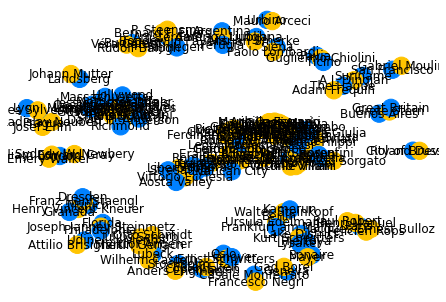

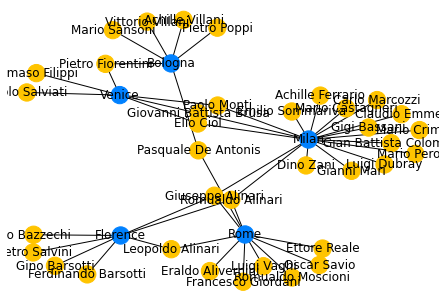

In [7]:
G = nx.MultiGraph()
name_file = open('worklocation.json')
data = json.load(name_file)
color_map = []
graphdict = defaultdict()

for row in data["results"]["bindings"]:
    if "worklabel" in row.keys():  
        newk = row["worklabel"]["value"]
        if newk not in graphdict.keys():
            graphdict[newk] = list()

for row in data["results"]["bindings"]:
    if "worklabel" in row.keys(): 
        newv =  row['label']['value']
        city = row['worklabel']['value']
        citizenship = row['worklabel']['value']
        if city in graphdict.keys():
            graphdict[city].append(newv)

for key in graphdict: 
    G.add_node(key, vote="city")
    for value in graphdict[key]:
        G.add_node(value, vote="person")
        G.add_edge(key, value)
        

color_map = []
for node, data in G.nodes(data=True):
    if data['vote'] == 'city':
        color_map.append(0.25)  # blue color
    elif data['vote'] == 'person':
        color_map.append(0.7)  # yellow color

nx.draw(G, vmin=0, vmax=1, cmap=plt.cm.jet, node_color=color_map, with_labels=True)
plt.show()

#with open('graph.json', 'w') as outfile:
    #json.dump(json_graph.node_link_data(G))
#x = json_graph.node_link_data(G)
#afterparty_trash('graph.json', x)

    
#italian cities with >= 4 are: Rome, Bologna, Milan, Florence, Venice
higher_n_cities = defaultdict()
italian_cities = ['Rome','Bologna','Milan','Florence','Venice']
for c in italian_cities:
    higher_n_cities[c] = list()

IC = nx.MultiGraph()

for key in graphdict:  
    for key2 in higher_n_cities:
        if key == key2: 
            higher_n_cities[key2] = graphdict[key].copy()

for key in higher_n_cities: 
    IC.add_node(key, vote="city")
    for value in higher_n_cities[key]:
        IC.add_node(value, vote="person")
        IC.add_edge(key, value)


color_map = []
for node, data in IC.nodes(data=True):
    if data['vote'] == 'city':
        color_map.append(0.25)  # blue color
    elif data['vote'] == 'person':
        color_map.append(0.7)  # yellow color        


nx.draw(IC, vmin=0, vmax=1, cmap=plt.cm.jet, node_color=color_map, with_labels=True)
plt.show()

In [ ]:
#with open('graph.json', 'w') as outfile:
    #json.dump(json_graph.node_link_data(G))
#x = json_graph.node_link_data(G)
#afterparty_trash('graph.json', x)

<h2 style="color:#98C1D9">Relationships: Heuristic networks</h2>
<p>After these first interesting networks, we decided to take one step further.</p> 
<p>The aim of this list of networks of connected components is to give hints to the historians of photography to further investigate the documents, the history and the traces left by the photographers themselves.</p> 
<p>This reasoning is given by the simple realization that deduction of real relationships between the photographers cannot be proven by this data alone.</p>

In [8]:
import numpy as np
import pandas as pd
import string
import networkx as nx
import matplotlib.pyplot as plt
import json 
from networkx.readwrite.json_graph.node_link import node_link_data
from networkx.readwrite import json_graph;

<p>First we need a .csv file (this time we didn't use a .json due to the different structure of the function we came to below) that includes both work locations and birth dates.</p>

In [95]:
workbirths_query= """
select ?photographer ?label (group_concat(distinct ?worklabel; separator=", ") as ?worklabels) ?birth
where {VALUES ?photographer {"""+final_uris+"""} ?photographer rdfs:label ?label .
    FILTER(LANG(?label) = "en").  
    ?photographer wdt:P937 / rdfs:label ?worklabel .
           FILTER(LANG(?worklabel) = "en").  

    ?photographer wdt:P569 ?birth
                  
}
group by ?photographer ?label ?worklabels ?birth
"""
sparql.setQuery(workbirths_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

with open('workbirths.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['photographer', 'label', 'worklabels', 'birth'])
    for result in results["results"]["bindings"]:
        my_writer.writerow([result['photographer']['value'], result['label']['value'], result['worklabels']['value'], result['birth']['value']])

<p>The function <span style="color:#1fc600">extract_network()</span> takes as parameters a <b>pandas dataframe</b>, a <b>minimum birth date</b> and finally a <b>window</b> of years before and after which entities can be included via their birth date. A claryfing example:</p> 
<li>Romualdo Alinari was born in 1830. If the window_sz = 40 years, he will be included inside the 1800, 1830 and 1860 networks.</li>
<p>We chose a span of 40 years to create these networks that could, more of less, including only people being alive and possibly active in the same period. But since it is only a parameter it can be easily used again. We must state again for clarity that this is only a heuristic take.</p>
<p>The resulting network images show <b>connected components</b> of people that were <span style="color:#c70e0e">(1) born in the same time window</span> and <span style="color:#c70e0e">(2) worked in the same city</span>.</p>  

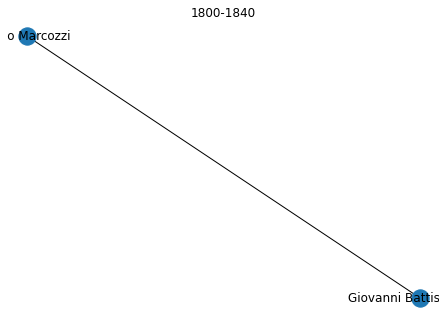

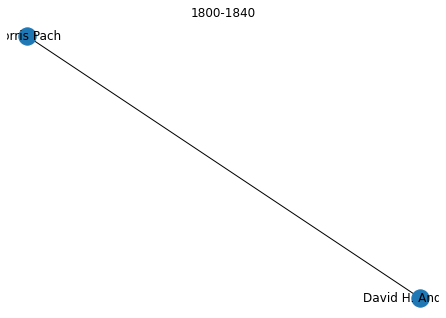

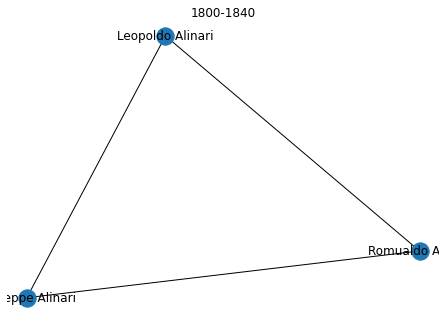

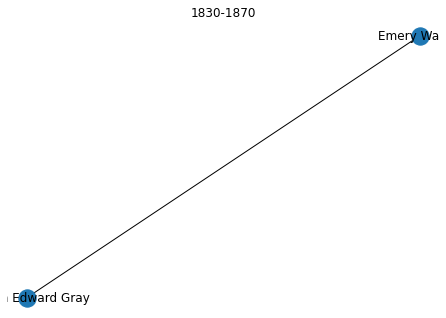

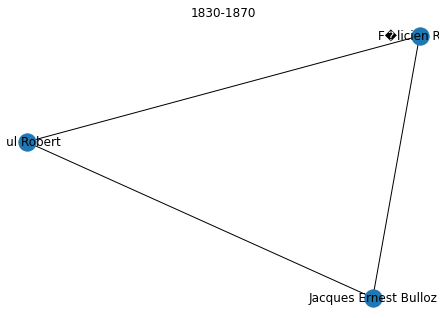

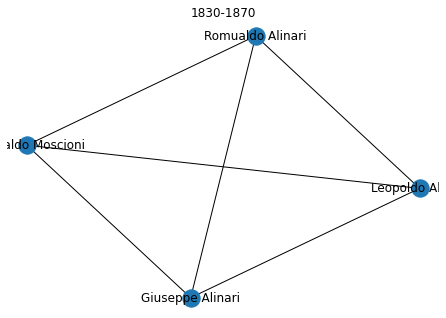

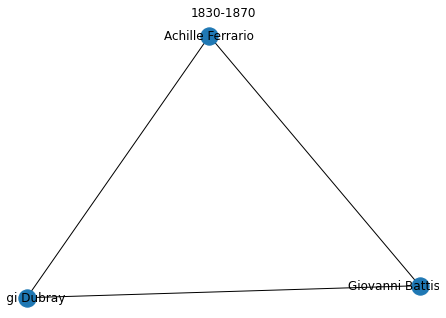

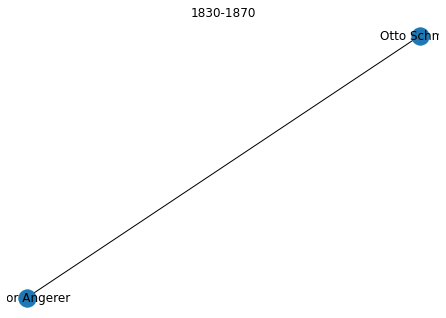

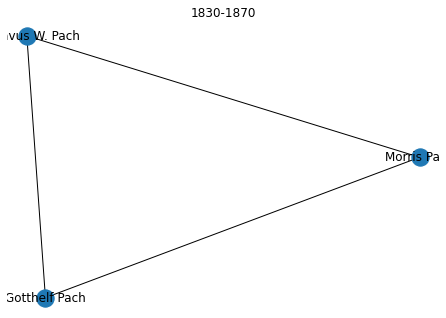

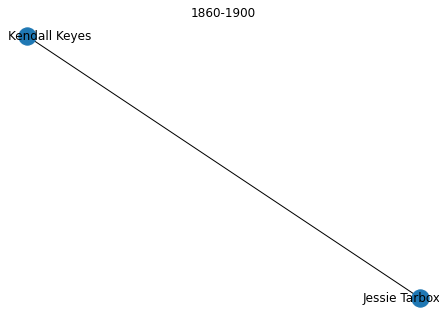

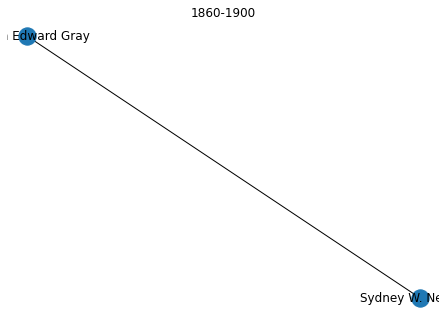

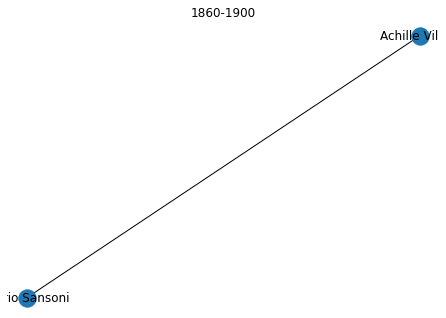

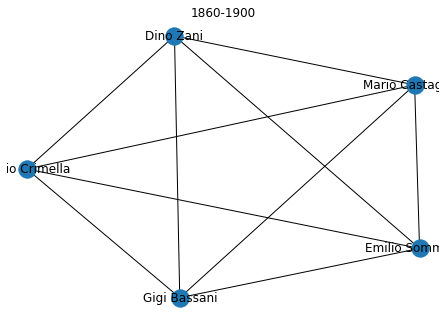

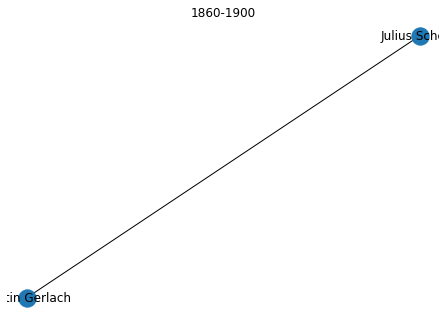

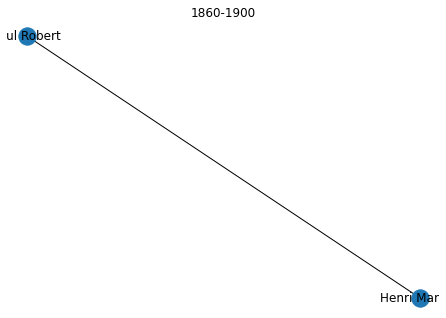

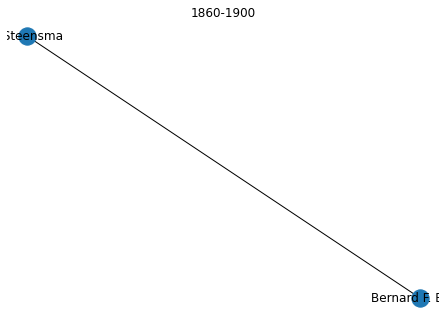

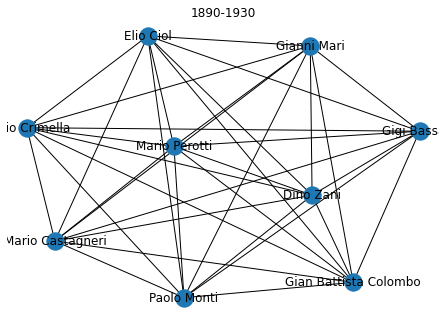

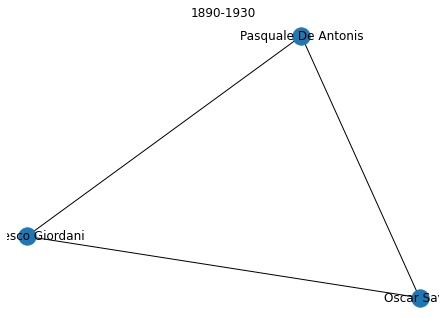

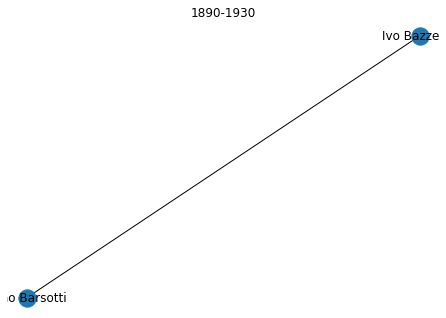

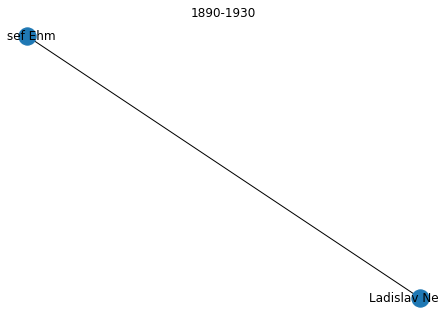

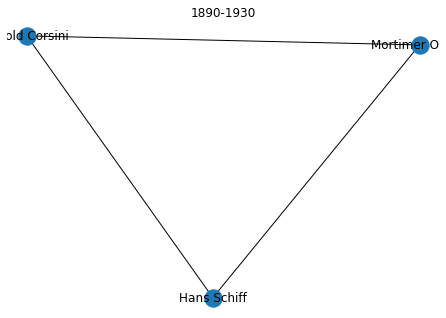

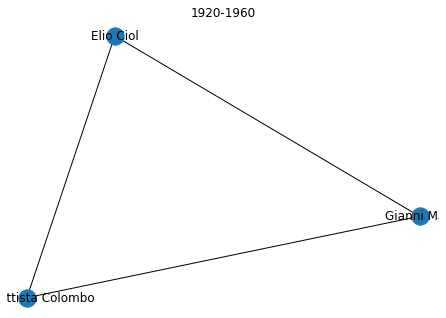

In [9]:
df = pd.read_csv('workbirths.csv', sep=',')
df['birth'] = pd.to_datetime(df['birth'])
df['year'] = df['birth'].dt.year
lbls = df['worklabels'].values
df['worklabels'] = [lbl.split(',') for lbl in lbls]

def extract_network(df, min_year, n_years):
    x = df[df.year >= min_year]
    x = x[x.year < min_year + n_years]
    net = nx.Graph() 
    for _, row1 in x.iterrows():
        z1 = row1.label
        cities1 = row1.worklabels
        for _, row2 in x.iterrows():
            z2 = row2.label
            net.add_node(z2)
            if(z1 != z2):
                cities2 = row2.worklabels
                res = list(np.intersect1d(cities1,cities2))
                if(len(res)>0):
                    net.add_edge(z1,z2,label=res)
    return net

networks = []
starting_years = (1800, 1830, 1860, 1890, 1920, 1950, 1980)
window_sz = 40
counter = 0
for s_year in starting_years:
    net = extract_network(df, s_year, window_sz)
    networks.append(net)
    conn_comps = nx.connected_components(net)
    for people in conn_comps:
        if(len(people)>1):
            S = net.subgraph(people).copy()
            nx.draw(S, with_labels=True)
            plt.title(str(s_year) + '-' + str(s_year+window_sz))
            plt.show()

<h2 style="color:#98C1D9">Data.json: at the end of the journey</h2>
<p>Reaching the end of our possibilities with the given data, we decided to serialize all the information about the photographers into a final .json file ("data.json"), ending this journey across Italy, Europe and the world.</p>

In [12]:
ssl._create_default_https_context = ssl._create_unverified_context

sparql = SPARQLWrapper("https://query.wikidata.org/bigdata/namespace/wdq/sparql")
sparql.setMethod(POST)

final_query= """
SELECT DISTINCT ?photographer ?label (group_concat(distinct ?occupation; separator=", ") as ?occupations) ?birth ?floruit ?birthplace ?death ?deathplace (group_concat(distinct ?worklocation; separator=", ") as ?worklocations) (group_concat(distinct ?citizenship; separator=", ") as ?citizenships) 
WHERE {VALUES ?photographer {"""+final_uris+"""}
       ?photographer rdfs:label ?label ;
       wdt:P106 ?occupation .
       OPTIONAL {?photographer wdt:P27 ?citizenship }.
       OPTIONAL {?photographer wdt:P1317 ?floruit}.
       OPTIONAL {?photographer wdt:P569 ?birth }.
       OPTIONAL {?photographer wdt:P19 ?birthplace}.
       OPTIONAL {?photographer wdt:P570 ?death}.
       OPTIONAL {?photographer wdt:P20 ?deathplace}.
       OPTIONAL {?photographer wdt:P937 ?worklocation }.
       FILTER(LANG(?label) = "en")
}
group by ?photographer ?label ?occupations ?floruit ?birth ?birthplace ?death ?deathplace ?worklocations ?citizenships


"""
sparql.setQuery(final_query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
afterparty_trash("data.json", results)
print(results)

{'head': {'vars': ['photographer', 'label', 'occupations', 'birth', 'floruit', 'birthplace', 'death', 'deathplace', 'worklocations', 'citizenships']}, 'results': {'bindings': [{'photographer': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q105986035'}, 'label': {'xml:lang': 'en', 'type': 'literal', 'value': 'Giovanni Battista Brusa'}, 'occupations': {'type': 'literal', 'value': 'http://www.wikidata.org/entity/Q33231'}, 'birth': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '1830-01-01T00:00:00Z'}, 'birthplace': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q490'}, 'death': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'type': 'literal', 'value': '1920-01-01T00:00:00Z'}, 'deathplace': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q490'}, 'worklocations': {'type': 'literal', 'value': 'http://www.wikidata.org/entity/Q490, http://www.wikidata.org/entity/Q641'}, 'citizenships': {'type': 'literal', 'value': 

We decided to use the OPTIONAL command to save as much data as possible, and to let the IDs shown. In some cases nor birth nor death were present, and we noticed sometimes the <i>floruit</i> property, which is extracted in more or less 4 occurrences. 
Here is a comprehensive list of all the data in the final .json: 
<ul>
    <li><span style="color:#3D5A80"> wdt:P106 ?occupation: the occupation(s) the photographers had during their lives</span> </li>
    <li><span style="color:#98C1D9"> wdt:P27 ?citizenship: the citizenships(s) they had</span> </li>
    <li><span style="color:#153B50"> wdt:P1317 ?floruit: when the photographer was active, in case no birth date is given</span> </li>
    <li><span style="color:#EE6C4D"> wdt:P569 ?birth: birth date of the photographer </span></li>
    <li><span style="color:#293241"> wdt:P19 ?birthplace: birth place of the photographer </span></li>
    <li><span style="color:#96C9DC"> wdt:P570 ?death: death birth of the photographer </span></li>
    <li><span style="color:#61A0AF"> wdt:P20 ?deathplace: death place of the photographer </span></li>
    <li><span style="color:#F06C9B"> wdt:P937 ?worklocation: work location(s) of the photographer</span> </li>

<div style="text-align:center">
<h2 style="color:#16F4D0">In loving memory of FOAF (the cat)</h2>
        <p style="text-align:center">2020-2021</p>
<img src="foaf.jpeg" style="width:300px; border-radius:2em;">

</div>